# Titre 
explain

Nous avons fait le choix de nous concentrer sur l'action de NVIDIA car ... 

# A. Récupération des données 

Nous utilisons Yahoo Finance (via yfinance) pour récupérer les séries boursières car c’est une source simple d’accès, largement utilisée pour des données daily OHLCV (Open, High, Low, Close, Volume), et crédible. 

L’objectif est de construire une base fiable et reproductible en combinant trois sources :
- NVDA (Yahoo Finance) : données quotidiennes sur NVIDIA (OHLCV, Adj Close, dividendes et splits). C’est la base principale du projet.
- ETFs (Yahoo Finance) : séries quotidiennes SPY / QQQ / SOXX pour capturer le contexte marché / tech / semi-conducteurs et distinguer les chocs “systématiques” des effets spécifiques à NVDA.
- FRED (pandas-datareader) : indicateurs macro-financiers VIX (régime de volatilité) et taux US 10 ans (conditions financières), utilisés comme variables de régime.

Enfin, toutes les séries sont alignées sur un calendrier unique (les dates de cotation de NVDA) afin de garantir la cohérence temporelle. Nous sauvegardons systématiquement les données en deux étapes (raw puis processed) pour assurer la reproductibilité : le projet peut être rejoué à l’identique sans dépendre d’un nouvel appel aux sources externes, ce qui fournit un backup si la disponibilité ou la structure des données venait à évoluer.

Cet axe s'articule en deux temps :
- Importation des données 
- Nettoyage et manipulation

## A.1 - Importation des données 

Dans cette partie, nous construisons la base de données qui servira pour la suite du projet. L’objectif est de **fusionner trois sources** (NVDA, ETFs et indicateurs FRED) en un **dataset unique** et cohérent.

On commence par importer ce qu'il faut :

In [155]:
import pandas as pd
from pandas_datareader import data as web
from pathlib import Path
import yfinance as yf 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Ensuite, nous définissons les **chemins de sauvegarde** (*paths*) pour stocker des copies locales des données (*backups*), afin de garantir la **reproductibilité** et d’éviter de retélécharger systématiquement les séries. Nous fixons également les **paramètres d’extraction** : dates de début et de fin, ainsi que les tickers récupérés via Yahoo Finance.


In [31]:
#Période d’étude : 10 ans
start_date = "2015-01-01"
end_date   = "2024-12-31"

#Sélection des tickers/séries d’intérêt (ETFs + indicateurs macro) 
etf_tickers  = ["SPY", "QQQ", "SOXX"]
fred_series  = ["VIXCLS", "DGS10"]
ticker = "NVDA"

#Gestion des paths : création du dossier raw et définition des fichiers de sauvegarde
RAW_DIR = Path("data/raw")
RAW_DIR.mkdir(parents=True, exist_ok=True)
nvda_raw_path = RAW_DIR / "nvda_stock_data_raw.csv"
etf_raw_path  = RAW_DIR / "etf_stock_data_raw.csv"
fred_raw_path = RAW_DIR / "fred_macro_raw.csv"

### A.1.1 - Téléchargements

On télécharge ensuite les trois bases de données (NVDA, ETFs et séries FRED) et on les affiche systématiquement afin de vérifier rapidement la cohérence de l’output (format, variables présentes, ordre temporel).

In [125]:
## Téléchargement des données de NVIDIA

#Si le fichier raw existe déjà, on le recharge (évite de retélécharger à chaque exécution)
if nvda_raw_path.exists():
    nvda_data = pd.read_csv(nvda_raw_path, parse_dates=["Date"])

#Sinon, on télécharge NVDA via Yahoo
else:
    nvda_data = yf.download(
        ticker,
        start=start_date,
        end=end_date).reset_index()

    nvda_data = nvda_data.rename(columns={c: f"{c}_{ticker}" for c in nvda_data.columns if c != "Date"})
    
    #Save en cache pour la reproductibilité 
    nvda_data.to_csv(nvda_raw_path, index=False)

#Affihcage de contrôle de la cellue 
nvda_data.head()

,Date,Close,High,Low,Open,Volume
0,NaT,NVDA,NVDA,NVDA,NVDA,NVDA
1,2015-01-02,0.4830114245414734,0.4866106406352872,0.4753331350130699,0.4830114245414734,113680000
2,2015-01-05,0.47485336661338806,0.4844512308997415,0.47269386502633765,0.48301154410583685,197952000
3,2015-01-06,0.4604564905166626,0.4760529693490393,0.45997660458104156,0.4755730834134183,197764000
4,2015-01-07,0.45925673842430115,0.4678947992489874,0.4578170520855876,0.46381569749056484,321808000


In [127]:
## Téléchargment de ETFs + FRED

#ETFs : (pareil que pour NVDA)
if etf_raw_path.exists():
    etf_data = pd.read_csv(etf_raw_path, parse_dates=["Date"])
else:
    etf = yf.download(
        etf_tickers,
        start=start_date,
        end=end_date,
        group_by="column")
    etf.columns = [f"{field}_{tic}" for field, tic in etf.columns]
    etf_data = etf.reset_index()
    etf_data.to_csv(etf_raw_path, index=False)

#FRED(VIXCLS, DGS10) : (pareil que pour NVDA)
if fred_raw_path.exists():
    fred_data = pd.read_csv(fred_raw_path, parse_dates=["DATE"])
else:
    fred_data = web.DataReader(fred_series, "fred", start_date, end_date).reset_index()
    fred_data.to_csv(fred_raw_path, index=False)

#Affihcages de contrôle de la cellue 
fred_data.head()
etf_data.head()

[*********************100%***********************]  3 of 3 completed


,Date,Close_QQQ,Close_SOXX,Close_SPY,High_QQQ,High_SOXX,High_SPY,Low_QQQ,Low_SOXX,Low_SPY,Open_QQQ,Open_SOXX,Open_SPY,Volume_QQQ,Volume_SOXX,Volume_SPY
0,2015-01-02,94.784409,27.559071,170.589584,95.944578,27.861950,171.793678,94.324022,27.300733,169.551581,95.539442,27.704572,171.378477,31314600,663000,121465900
1,2015-01-05,93.394066,27.039429,167.508804,94.480579,27.493748,169.709366,93.127041,27.030520,167.201559,94.370084,27.443270,169.543288,36521300,619500,169632600
2,2015-01-06,92.141823,26.436642,165.931046,93.688723,27.083973,168.339208,91.727477,26.359438,165.133853,93.532193,27.057248,167.816050,66205500,1123800,209151400
3,2015-01-07,93.329620,26.697945,167.998779,93.550604,26.816721,168.339247,92.528545,26.430699,166.811309,92.749535,26.588077,167.259721,37577400,721200,125346700
4,2015-01-08,95.115921,27.490776,170.979950,95.300073,27.535316,171.195863,94.020198,26.968159,169.393890,94.121484,26.968159,169.410489,40212600,633000,147217800


### A.1.2 - Merge

Ensuite, on fusionnon les trois bases (NVDA, ETFs et FRED) afin d’obtenir un dataset unique, prêt pour les étapes de contrôle qualité et de préparation des variables.

In [128]:
## Création de la base finale   

#Mise à plat des noms de colonnes : yfinance peut produire un MultiIndex (ex. ("Close","NVDA"))
if isinstance(nvda_data.columns, pd.MultiIndex):
    nvda_data.columns = [
        f"{a}_{b}" if (b is not None and b != "") else str(a)
        for a, b in nvda_data.columns
    ]
else:
    nvda_data.columns = [
        "_".join(map(str, c)).strip() if isinstance(c, tuple) else str(c)
        for c in nvda_data.columns
    ]

#S’assurer que NVDA a bien des colonnes suffixées _NVDA (sinon on les renomme)
if not any(str(c).endswith("_NVDA") for c in nvda_data.columns if c != "Date"):
    nvda_data = nvda_data.rename(columns={c: f"{c}_NVDA" for c in nvda_data.columns if c != "Date"})

#On repart d’une base NVDA “clean” (NVDA uniquement) pour éviter les doublons en cas de relance
nvda_cols = ["Date"] + [c for c in nvda_data.columns if str(c).endswith("_NVDA")]
nvda_base = nvda_data[nvda_cols].copy()

#Flatten ETFs si besoin (MultiIndex) ---
if isinstance(etf_data.columns, pd.MultiIndex):
    etf_data.columns = [
        f"{a}_{b}" if (b is not None and b != "") else str(a)
        for a, b in etf_data.columns
    ]
else:
    etf_data.columns = [
        "_".join(map(str, c)).strip() if isinstance(c, tuple) else str(c)
        for c in etf_data.columns
    ]

#On a remarqué que le nom de variable de la date est différent entre FRED et NVDA
#On renomme simplement cette variable pour merge : "DATE" -> "Date"
if "DATE" in fred_data.columns and "Date" not in fred_data.columns:
    fred_data = fred_data.rename(columns={"DATE": "Date"})

#Mise au bon format et tri chronologique pour le merge temporel
for df in [nvda_base, etf_data, fred_data]:
    df["Date"] = pd.to_datetime(df["Date"])
    df.sort_values("Date", inplace=True)

#Indexation selon les dates de cotation NVDA
nvda_idx = nvda_base.set_index("Date")
etf_idx  = etf_data.set_index("Date")
fred_idx = fred_data.set_index("Date")

#Alignement sur les dates NVDA + forward-fill sur FRED
etf_aligned  = etf_idx.reindex(nvda_idx.index)
fred_aligned = fred_idx.reindex(nvda_idx.index).ffill()

#Merge
nvda_data_2 = (
    nvda_idx
    .join(etf_aligned, how="left")
    .join(fred_aligned, how="left")
    .reset_index()
)

#Sauvegarde
PROCESSED_DIR = Path("data/processed")
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

processed_parquet = PROCESSED_DIR / "nvda_data_2.parquet"
processed_csv     = PROCESSED_DIR / "nvda_data_2.csv"

try:
    nvda_data_2.to_parquet(processed_parquet, index=False)
    print("Saved parquet:", processed_parquet)
except ImportError:
    nvda_data_2.to_csv(processed_csv, index=False)
    print("Parquet engine missing -> saved CSV instead:", processed_csv)

#Affichage de contrôle
print("Merged nvda_data_2 shape:", nvda_data_2.shape)
nvda_data_2.head()

Parquet engine missing -> saved CSV instead: data/processed/nvda_data_2.csv
Merged nvda_data_2 shape: (2516, 23)


,Date,Close_NVDA,High_NVDA,Low_NVDA,Open_NVDA,Volume_NVDA,Close_QQQ,Close_SOXX,Close_SPY,High_QQQ,...,Low_SOXX,Low_SPY,Open_QQQ,Open_SOXX,Open_SPY,Volume_QQQ,Volume_SOXX,Volume_SPY,VIXCLS,DGS10
0,2015-01-02,0.4830114245414734,0.4866106406352872,0.4753331350130699,0.4830114245414734,113680000,94.784409,27.559071,170.589584,95.944578,...,27.300733,169.551581,95.539442,27.704572,171.378477,31314600.0,663000.0,121465900.0,17.79,2.12
1,2015-01-05,0.47485336661338806,0.4844512308997415,0.47269386502633765,0.48301154410583685,197952000,93.394066,27.039429,167.508804,94.480579,...,27.030520,167.201559,94.370084,27.443270,169.543288,36521300.0,619500.0,169632600.0,19.92,2.04
2,2015-01-06,0.4604564905166626,0.4760529693490393,0.45997660458104156,0.4755730834134183,197764000,92.141823,26.436642,165.931046,93.688723,...,26.359438,165.133853,93.532193,27.057248,167.816050,66205500.0,1123800.0,209151400.0,21.12,1.97
3,2015-01-07,0.45925673842430115,0.4678947992489874,0.4578170520855876,0.46381569749056484,321808000,93.329620,26.697945,167.998779,93.550604,...,26.430699,166.811309,92.749535,26.588077,167.259721,37577400.0,721200.0,125346700.0,19.31,1.96
4,2015-01-08,0.47653284668922424,0.4794122194586118,0.4642955982307224,0.4645355554961042,283780000,95.115921,27.490776,170.979950,95.300073,...,26.968159,169.393890,94.121484,26.968159,169.410489,40212600.0,633000.0,147217800.0,17.01,2.03


**CCL** : À ce stade, nous disposons des bases suivantes :

* `nvda_data_2` : base principale fusionnée (NVDA + ETFs + FRED), utilisée pour la suite du projet.
* `nvda_stock_data_raw` : données brutes NVDA (Yahoo Finance), sauvegardées dans `data/raw`.
* `etf_stock_data_raw` : données brutes ETFs (SPY, QQQ, SOXX) issues de Yahoo Finance, sauvegardées dans `data/raw`.
* `fred_stock_data_raw` : données brutes FRED (VIXCLS, DGS10), sauvegardées dans `data/raw`.


## A.2 - Nettoyage et Manipulation des données

Dans cette section, nous analysons et mettons au propre 
- les bases de données brutes téléchargées
- la base complète `nvda_data_2`, obtenue après fusion des données NVDA, ETFs et FRED. 

L’objectif est de vérifier la qualité du merge (cohérence temporelle, doublons) et de préparer une base exploitable pour la suite du projet.

### A.2.1 - Bases de donées brutes

#### A.2.1.1 - Bases de donées brutes : Nettoyage

In [129]:
#rappel du dossier de sortie
PROCESSED_DIR = Path("data/processed")
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

#rappel des paths
RAW = [etf_raw_path, fred_raw_path, nvda_raw_path]

#Fonction pour éviter les copier/collé
def nettoyage(path):
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip()

    # Détection de la colonne date : Date / DATE / *date*
    date_col = next((c for c in df.columns if c.lower() == "date"), None)
    if date_col is None:
        date_col = next((c for c in df.columns if "date" in c.lower()), None)

    if date_col is None:
        raise ValueError(f"Aucune colonne date détectée dans {path}")

    #Parsing + renommage en 'Date'
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    if date_col != "Date":
        df = df.rename(columns={date_col: "Date"})
    date_col = "Date"

    #Conversion du reste en numérique (les valeurs non numériques deviennent NaN)
    for c in df.columns:
        if c != date_col:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    n0 = len(df)

    #Suppression lignes entièrement vides + lignes où la date est invalide/manquante
    df = df.dropna()
    n1 = len(df)

    #Suppression doublons (sur la date)
    df = df.sort_values(date_col).drop_duplicates(subset=[date_col], keep="last")
    df = df.sort_values(date_col).reset_index(drop=True)
    n2 = len(df)

    out_path = PROCESSED_DIR / Path(path).name.replace("_raw", "_clean")
    df.to_csv(out_path, index=False)

    print(f"{path}: {n0} -> {n1} (lignes supprimées: {n0-n1}) -> {n2} (doublons supprimés: {n1-n2})")
    print(f"   enregistré dans: {out_path}\n")

    return out_path

# Nettoyage de tous les fichiers
outputs = [nettoyage(f) for f in RAW]
outputs

#Import des bases clean
etf_stock_data_clean  = pd.read_csv(PROCESSED_DIR / "etf_stock_data_clean.csv", parse_dates=["Date"])
fred_stock_data_clean = pd.read_csv(PROCESSED_DIR / "fred_macro_clean.csv",      parse_dates=["Date"])
nvda_stock_data_clean = pd.read_csv(PROCESSED_DIR / "nvda_stock_data_clean.csv", parse_dates=["Date"])


data/raw/etf_stock_data_raw.csv: 2515 -> 2515 (lignes supprimées: 0) -> 2515 (doublons supprimés: 0)
   enregistré dans: data/processed/etf_stock_data_clean.csv

data/raw/fred_macro_raw.csv: 2609 -> 2498 (lignes supprimées: 111) -> 2498 (doublons supprimés: 0)
   enregistré dans: data/processed/fred_macro_clean.csv

data/raw/nvda_stock_data_raw.csv: 2516 -> 2515 (lignes supprimées: 1) -> 2515 (doublons supprimés: 0)
   enregistré dans: data/processed/nvda_stock_data_clean.csv



**Commentaire** : Lors du nettoyage du fichier 
- ETF et NVDA : RAS
- FRED : 111 observations ont été supprimées car la procédure appliquée (dropna()) élimine toute ligne contenant au moins une valeur manquante dans l’une des variables. Cette étape permet d’obtenir un sous-échantillon entièrement complet (aucun NA). En contrepartie, elle réduit l’horizon temporel effectif en ne conservant que les dates pour lesquelles toutes les séries sont renseignées, ce qui peut concentrer l’analyse sur la période commune de disponibilité des indicateurs.

On remarque que l'on aurait pu : 

Nettoyer -> Merge. 

Au lieu de : 

Merge -> Nettoyer. 

#### A.2.1.2 - Bases de données brutes : Analyse rapide

On calcule maintenant l’asymétrie (*skewness*) de la distribution, afin de caractériser si la variable étudiée présente une dissymétrie marquée (présence plus fréquente d’extrêmes positifs ou négatifs). 

In [138]:
nvda_stock_data_clean["ret_NVDA"] = nvda_stock_data_clean["Close"].pct_change()
print("Skewness ret_NVDA (rendements):", nvda_stock_data_clean["ret_NVDA"].dropna().skew())

Skewness ret_NVDA (rendements): 0.626106052571398


**Interprétation** : la *skewness* mesure l’**asymétrie** d’une distribution autour de sa moyenne. 
- Une skewness **positive** signifie que la distribution présente une **queue à droite** plus longue : on observe plus souvent des **hausses extrêmes** que des baisses extrêmes (ou, dit autrement, quelques jours de très fortes hausses tirent la distribution vers la droite). 
- Ici, `skewness = 0.627` indique une asymétrie positive **modérée** des rendements journaliers de NVDA.

**Exemple illustratif** : si la plupart des jours se situent autour de −1% à +1%, mais qu’il existe ponctuellement des journées à +6% / +10% plus fréquentes ou plus “fortes” que les journées à −6% / −10%, la skewness devient positive.

**Pourquoi calculer sur les rendements plutôt que sur les prix ?** Les prix sont non stationnaires et dominés par une tendance de long terme, ce qui rend leur distribution peu interprétable. Les **rendements** (variations relatives) sont l’objet standard en finance : ils permettent de comparer les mouvements dans le temps et entre actifs, et décrivent directement le risque (variabilité, asymétrie, extrêmes).

### A.2.2 - `nvda_data_2`

#### A.2.1.1 - `nvda_data_2` : Nettoyage
 On commence par l’identification et le traitement des valeurs manquantes.

In [131]:
#Diagnostic des valeurs manquantes
na_counts = nvda_data_2.isna().sum().sort_values(ascending=False)
print("Top colonnes avec NA (si > 0) :")
print(na_counts[na_counts > 0].head(15))
print("Top colonnes sans NA :")
print(na_counts[na_counts == 0].head(15))

Top colonnes avec NA (si > 0) :
Date           1
Low_QQQ        1
Volume_SPY     1
Volume_SOXX    1
Volume_QQQ     1
Open_SPY       1
Open_SOXX      1
Open_QQQ       1
Low_SPY        1
Low_SOXX       1
High_SPY       1
High_SOXX      1
High_QQQ       1
Close_SPY      1
Close_SOXX     1
dtype: int64
Top colonnes sans NA :
Close_NVDA     0
Volume_NVDA    0
Open_NVDA      0
Low_NVDA       0
High_NVDA      0
VIXCLS         0
DGS10          0
dtype: int64


**Interprétation** : pas beaucoup de valeurs manquantes. C’est cohérent avec les séries issues de Yahoo Finance, généralement complètes sur les jours de cotation. 

In [132]:
#drop des valeurs NA
nvda_data_2 = nvda_data_2.dropna()

In [133]:
dup_dates = nvda_data_2["Date"].duplicated().sum()
print("\nNombre de dates dupliquées:", dup_dates)

#Si doublons : on garde la dernière occurrence (par convention)
if dup_dates > 0:
    nvda_data_2 = nvda_data_2.drop_duplicates(subset=["Date"], keep="last").reset_index(drop=True)


Nombre de dates dupliquées: 0


Aucun doublon de date n’est détecté : la base est donc cohérente sur la dimension temporelle et peut être utilisée telle quelle pour la suite. 

#### A.2.1.2 - `nvda_data_2` : Analyse rapide

In [134]:
desc_full = nvda_data_2.describe().T
desc_full.head(15)

,count,mean,min,25%,50%,75%,max,std
Date,2515,2019-12-31 01:37:54.512922624,2015-01-02 00:00:00,2017-07-01 12:00:00,2019-12-31 00:00:00,2022-06-29 12:00:00,2024-12-30 00:00:00,NaN
Close_QQQ,2515.0,236.695524,89.586853,133.226067,195.457916,327.252991,534.592285,117.789245
Close_SOXX,2515.0,95.634714,22.68961,44.91572,72.783035,140.069489,262.575653,61.532319
Close_SPY,2515.0,310.206377,154.980835,212.165359,273.141632,399.227493,598.740112,114.384025
High_QQQ,2515.0,238.366715,90.265847,133.700049,196.266733,330.488641,535.565811,118.622746
High_SOXX,2515.0,96.670053,22.928833,45.188759,73.374606,141.639503,264.306453,62.291179
High_SPY,2515.0,311.838859,156.031787,212.809382,273.791119,401.460822,599.98132,114.936658
Low_QQQ,2515.0,234.774196,78.385661,132.659756,194.273656,325.273887,530.579217,116.852412
Low_SOXX,2515.0,94.503078,21.749315,44.526003,71.712409,138.220518,257.719548,60.729951
Low_SPY,2515.0,308.330377,152.881636,211.415776,272.1961,396.570811,597.961923,113.744518


In [135]:
max_close = nvda_data_2["Close_NVDA"].max() 
min_close = nvda_data_2["Close_NVDA"].min()
date_max = nvda_data_2.loc[nvda_data_2["Close_NVDA"].idxmax(), "Date"]
date_min = nvda_data_2.loc[nvda_data_2["Close_NVDA"].idxmin(), "Date"]
print("Le prix de cloture minimal est :", min_close, "le :", date_min)
print("Le prix de cloture maximal est :", max_close, "le :", date_max)

Le prix de cloture minimal est : 0.45925673842430115 le : 2015-01-07 00:00:00
Le prix de cloture maximal est : 98.86768341064453 le : 2024-08-07 00:00:00


**Interprétation** : Le prix de l'action NVIDIA a été multiplié par un **facteur quasiment de 200 !!** sur la période étudiée. Il fallait donc investir.

Fin de la récupération et du traitement des données. 

A ce stade, on dispose des bases suivantes interessantes :
* `nvda_data_2` : base principale fusionnée (NVDA + ETFs + FRED), utilisée pour la suite du projet. Qui a été nettoyée. 
* `nvda_stock_data_clean` : données brutes NVDA nettoyées. 
* `etf_stock_data_clean` : données brutes etf nettoyées. 
* `fred_stock_data_clean` : données brutes fred nettoyées. 

# B. Analyse descriptive et visualisation

Dans cette partie, nous réalisons une analyse descriptive à partir de la base principale `nvda_data_2` (NVDA + ETFs + FRED).  


L’objectif est de caractériser les dynamiques de prix et de volume de NVDA, d’identifier des épisodes extrêmes (volatilité, drawdown), et de replacer ces évolutions dans leur contexte marché/secteur et macro-financier.

L'axe s'articule en 6 moments : 
- Préparation des variables descriptives 
- Prix de NVDA et tendances 
- Rendements et volatilité réalisée 
- Mise en contexte : comparaison NVDA vs SPY/QQQ/SOXX et régime de risque 
- Distribution et épisodes extrêmes (histogramme, drawdown, |ret| vs volume)
- Corrélations ciblées sur variations (returns et différences macro).

## B.1 — Préparation des variables descriptives

On prépare ici les variables nécessaires à l’analyse descriptive.

- À partir de `nvda_data_2` (base globale), on construit une sous-base `nvda_data` (NVDA-only) pour les graphiques centrés sur NVIDIA.
- On calcule ensuite des indicateurs standards :
  - **rendement journalier** `ret_NVDA` pour analyser les variations relatives plutôt que les niveaux de prix,


  - **moyennes mobiles** (20/50/200 jours) pour visualiser les tendances court/moyen/long terme,


  - **volatilité réalisée** `vol20` (écart-type glissant des rendements) pour repérer les changements de régime,


  - **performance cumulée** `cumret_NVDA` et **drawdown** `drawdown_NVDA` pour mesurer les épisodes de pertes et la dynamique de récupération.


- En parallèle, on prépare des variables de **contexte** (ETFs et FRED) sous forme de rendements/variations (returns des ETFs, ΔVIX, Δtaux 10 ans), afin de comparer NVDA à son environnement marché/secteur et macro-financier. Voir est-ce que c'est NVIDIA qui a perf ou est-ce que c'est une tendance globale sur le marché. 

**Remarque** : `nvda_data` est reconstruit à partir de `nvda_data_2` afin de conserver une source unique cohérente (mêmes dates, mêmes conventions de noms `*_NVDA`) et d’éviter d’utiliser `nvda_stock_data_clean`, qui correspond à une version antérieure du projet (NVDA seul) et peut introduire des incohérences.

In [172]:
#Sécurisation (Date + tri)
nvda_data_2["Date"] = pd.to_datetime(nvda_data_2["Date"])
nvda_data_2 = nvda_data_2.sort_values("Date").reset_index(drop=True)

#Vérification minimale
required = {"Date", "Close_NVDA", "Volume_NVDA"}
missing = required - set(nvda_data_2.columns)
if missing:
    raise ValueError(f"Colonnes manquantes dans nvda_data_2 : {missing}")

#on copie une sous bdd pour ne pas toucher à la bdd principale 
#sert pour les graphiques uniqument centrés autour du cours de NVIDIA
nvda_data = nvda_data_2[["Date", "Open_NVDA", "High_NVDA", "Low_NVDA", "Close_NVDA", "Volume_NVDA"]].copy()

Indicateurs relatifs à NVIDIA :

In [173]:
#Conversion explicite en numérique : certaines colonnes peuvent être importées comme chaînes,
#ce qui empêche les calculs. On nettoie puis on force le type numérique.

num_cols = ["Open_NVDA", "High_NVDA", "Low_NVDA", "Close_NVDA", "Volume_NVDA"]

for c in num_cols:
    if c in nvda_data.columns:
        nvda_data[c] = (
            nvda_data[c]
            .astype(str)
            .str.replace(",", ".", regex=False)   # au cas où décimales avec virgule
            .replace("None", np.nan)
        )
        nvda_data[c] = pd.to_numeric(nvda_data[c], errors="coerce")

#Indicateurs NVDA (EDA)
nvda_data["ret_NVDA"] = nvda_data["Close_NVDA"].pct_change()
nvda_data["MA20"] = nvda_data["Close_NVDA"].rolling(20).mean()
nvda_data["MA50"] = nvda_data["Close_NVDA"].rolling(50).mean()
nvda_data["MA200"] = nvda_data["Close_NVDA"].rolling(200).mean()
nvda_data["vol20"] = nvda_data["ret_NVDA"].rolling(20).std()
nvda_data["cumret_NVDA"] = (1 + nvda_data["ret_NVDA"]).cumprod() - 1
nvda_data["drawdown_NVDA"] = nvda_data["Close_NVDA"] / nvda_data["Close_NVDA"].cummax() - 1


Indicateurs relatifs au contexte (ETFs + FRED) :

**Remarque** : nous ne construisons pas ces variables de contexte directement dans la partie A pour laisser aussi plus de liberté pour tester différentes transformations et sélections de variables selon les analyses menées ensuite.

In [174]:
context_cols = ["Close_SPY", "Close_QQQ", "Close_SOXX", "VIXCLS", "DGS10"]
available_context = [c for c in context_cols if c in nvda_data_2.columns]

context_data = nvda_data_2[["Date"] + available_context].copy()

for c in ["Close_SPY", "Close_QQQ", "Close_SOXX"]:
    if c in context_data.columns:
        context_data[f"ret_{c.split('_')[1]}"] = context_data[c].pct_change()

if "VIXCLS" in context_data.columns:
    context_data["dVIX"] = context_data["VIXCLS"].diff()

if "DGS10" in context_data.columns:
    context_data["dDGS10"] = context_data["DGS10"].diff()

#Affichage de controle 
nvda_data.head()

,Date,Open_NVDA,High_NVDA,Low_NVDA,Close_NVDA,Volume_NVDA,ret_NVDA,MA20,MA50,MA200,vol20,cumret_NVDA,drawdown_NVDA
0,2015-01-02,0.483011,0.486611,0.475333,0.483011,113680000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1,2015-01-05,0.483012,0.484451,0.472694,0.474853,197952000,-0.016890,NaN,NaN,NaN,NaN,-0.016890,-0.016890
2,2015-01-06,0.475573,0.476053,0.459977,0.460456,197764000,-0.030319,NaN,NaN,NaN,NaN,-0.046696,-0.046696
3,2015-01-07,0.463816,0.467895,0.457817,0.459257,321808000,-0.002606,NaN,NaN,NaN,NaN,-0.049180,-0.049180
4,2015-01-08,0.464536,0.479412,0.464296,0.476533,283780000,0.037618,NaN,NaN,NaN,NaN,-0.013413,-0.013413


**CCL** : À ce stade, nous disposons d’une base NVDA-only (`nvda_data`) enrichie d’indicateurs EDA (rendements, moyennes mobiles, volatilité réalisée, performance cumulée, drawdown) et d’un jeu de variables de contexte dérivées de `nvda_data_2` (returns ETFs, ΔVIX, Δtaux). Ces éléments constituent le socle des visualisations et analyses descriptives des sections suivantes.


## B.2 — Prix de NVDA et tendances (moyennes mobiles)

On visualise l’évolution du prix de clôture de NVDA sur la période, ainsi que des moyennes mobiles (20, 50 et 200 jours) afin d’identifier des tendances de court/moyen/long terme et de situer les changements de régime.


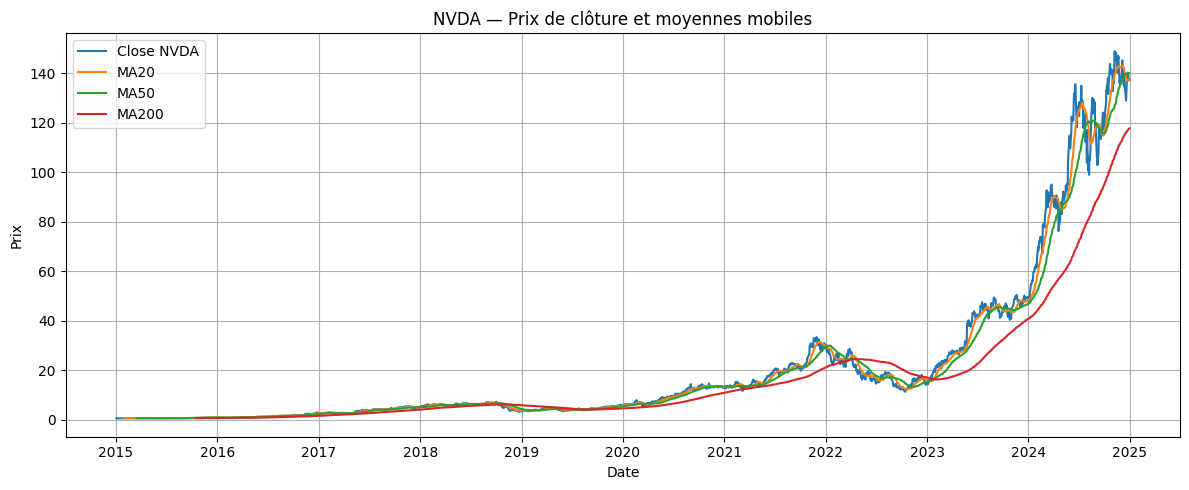

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(nvda_data["Date"], nvda_data["Close_NVDA"], label="Close NVDA")

#On trace les MAs uniquement si elles existent
for col, lab in [("MA20", "MA20"), ("MA50", "MA50"), ("MA200", "MA200")]:
    if col in nvda_data.columns:
        plt.plot(nvda_data["Date"], nvda_data[col], label=lab)

plt.title("NVDA — Prix de clôture et moyennes mobiles")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

**Interprétation** : Le graphique met en évidence une tendance haussière de long terme sur la période, avec une accélération marquée à partir de 2023–2024. 

Les moyennes mobiles jouent ici un rôle de lissage : 

- **MA20** et **MA50** suivent la dynamique de court/moyen terme (et réagissent rapidement aux phases de correction), 
- tandis que **MA200** capture la tendance structurelle. 

On observe des épisodes de repli (notamment autour de 2018–2019 et surtout en 2022), puis un retour en régime haussier lorsque le prix repasse durablement au-dessus des moyennes longues. 

## B.3 — Rendements et volatilité réalisée

On étudie ensuite les rendements journaliers et une mesure simple de volatilité réalisée (écart-type glissant sur 20 jours). Cela permet de repérer les périodes de forte variabilité et de justifier l’intérêt de variables de contexte (marché, secteur, régime de volatilité).


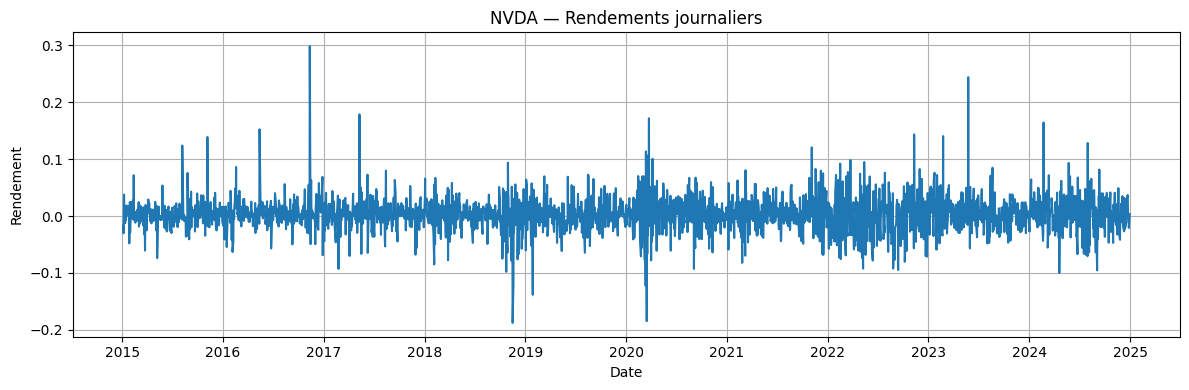

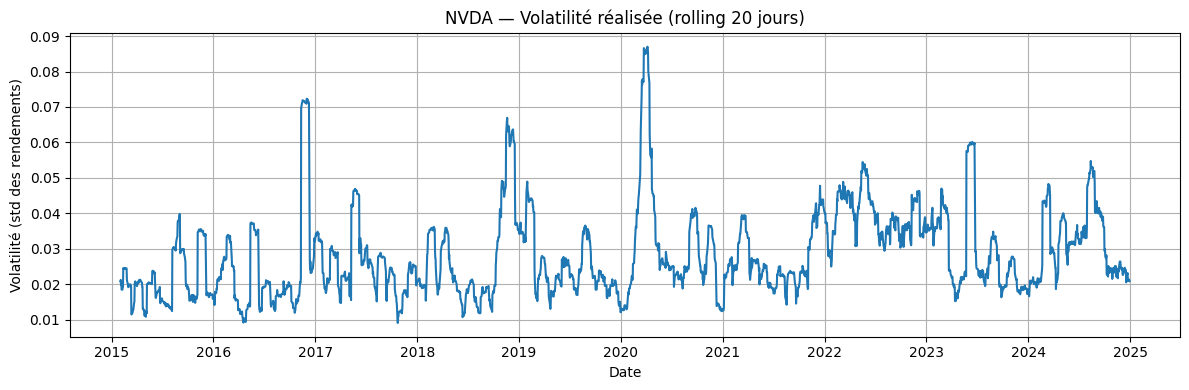

In [166]:
#Rendements
plt.figure(figsize=(12, 4))
plt.plot(nvda_data["Date"], nvda_data["ret_NVDA"])
plt.title("NVDA — Rendements journaliers")
plt.xlabel("Date")
plt.ylabel("Rendement")
plt.tight_layout()
plt.grid()
plt.show()

#Volatilité réalisée (20 jours)
if "vol20" in nvda_data.columns:
    plot_vol = nvda_data.dropna(subset=["Date", "vol20"]).copy()
    plt.figure(figsize=(12, 4))
    plt.plot(plot_vol["Date"], plot_vol["vol20"])
    plt.title("NVDA — Volatilité réalisée (rolling 20 jours)")
    plt.xlabel("Date")
    plt.ylabel("Volatilité (std des rendements)")
    plt.tight_layout()
    plt.grid()
    plt.show()

**Interprétations** : Les rendements journaliers de NVDA sont centrés autour de zéro, mais présentent des **pics ponctuels** (positifs et négatifs), ce qui traduit la présence d’épisodes de fortes variations sur une journée. 

La volatilité réalisée (écart-type glissant sur 20 jours) met en évidence une dynamique en **régimes** : 
- des phases calmes alternent avec des phases de stress où la dispersion des rendements augmente nettement. On observe notamment des hausses marquées de volatilité autour de 2016–2017, 2018–2019, et un pic particulièrement élevé autour de 2020, 
- puis de nouveaux épisodes plus modérés mais persistants sur 2022–2024. 

Cette structure justifie l’usage d’indicateurs de contexte (marché/secteur, VIX) et de variables glissantes dans la suite du projet, car le comportement de NVDA n’est pas stable dans le temps.

## B.4 — Mise en contexte : marché, secteur et régime de risque

Comme `nvda_data_2` intègre des ETFs (SPY, QQQ, SOXX) et des indicateurs FRED (VIX, taux 10 ans), on compare les dynamiques de NVIDIA à celles du marché et du secteur.  
L’objectif est de distinguer ce qui relève de facteurs “systématiques” (marché/secteur) et ce qui relève de comportements plus spécifiques à NVIDIA.


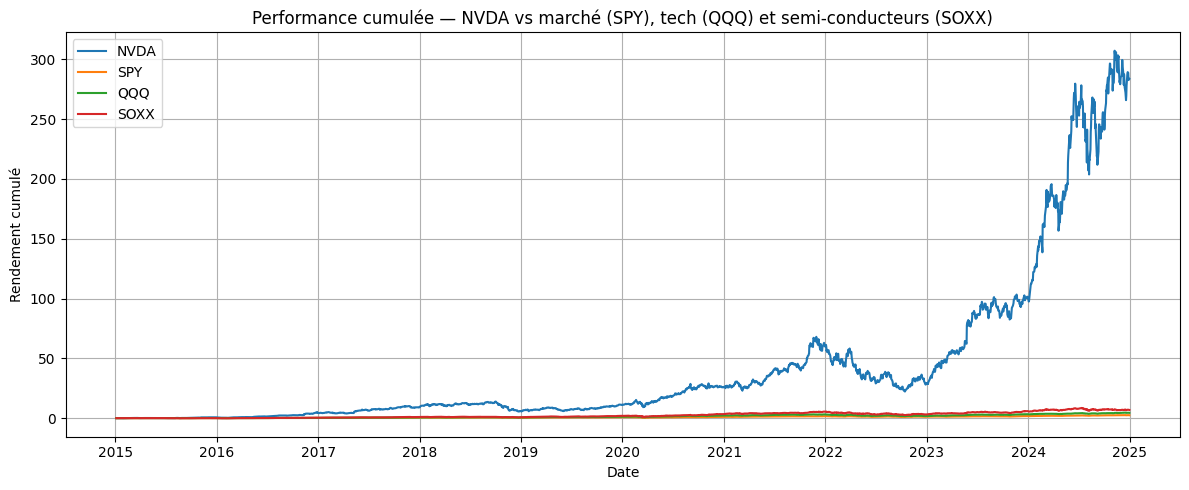

In [ ]:
#table de prix "comparables" dédiée à la comparaison (sans modifier nvda_data_2)

df_cmp = nvda_data_2[["Date", "Close_NVDA"]].copy()

#ajout des prix de clôture des ETFs (si disponibles) : marché (SPY), tech (QQQ), semi-conducteurs (SOXX)
for col in ["Close_SPY", "Close_QQQ", "Close_SOXX"]:
    if col in nvda_data_2.columns:
        df_cmp[col] = nvda_data_2[col]

#Conversion explicite en numérique : garantit que les opérations (pct_change, cumprod) fonctionnent correctement
for c in df_cmp.columns:
    if c != "Date":
        df_cmp[c] = pd.to_numeric(df_cmp[c], errors="coerce")
df_cmp = df_cmp.dropna().sort_values("Date").reset_index(drop=True)

#calcul des rendements journaliers puis des performances cumulées à partir des prix
df_ret = df_cmp.copy()
for c in df_cmp.columns:
    if c != "Date":
        df_ret[c] = df_cmp[c].pct_change()
df_ret = df_ret.dropna()

#on plot
plt.figure(figsize=(12, 5))
plt.plot(df_ret["Date"], (1 + df_ret["Close_NVDA"]).cumprod() - 1, label="NVDA")


if "Close_SPY" in df_ret.columns:
    plt.plot(df_ret["Date"], (1 + df_ret["Close_SPY"]).cumprod() - 1, label="SPY")
if "Close_QQQ" in df_ret.columns:
    plt.plot(df_ret["Date"], (1 + df_ret["Close_QQQ"]).cumprod() - 1, label="QQQ")
if "Close_SOXX" in df_ret.columns:
    plt.plot(df_ret["Date"], (1 + df_ret["Close_SOXX"]).cumprod() - 1, label="SOXX")

plt.title("Performance cumulée — NVDA vs marché (SPY), tech (QQQ) et semi-conducteurs (SOXX)")
plt.xlabel("Date")
plt.ylabel("Rendement cumulé")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

**Interprétations** : La performance cumulée met en évidence une **surperformance très marquée de NVDA** sur la période par rapport au marché (SPY), au secteur tech (QQQ) et à l’industrie des semi-conducteurs (SOXX). 

Ce graphique justifie **nettement** l’introduction des ETFs comme variables de contrôle. 

En gros : il fallait vraiment investir !

**Remarque** : sans entrer dans une analyse macro détaillée, la surperformance de NVDA sur la période s’explique en grande partie par son positionnement central dans la chaîne de valeur de l’IA, et par la montée en puissance des besoins en calcul dans les data centers. Dans ce contexte, NVDA apparaît comme un acteur particulièrement exposé aux cycles d’investissement technologique, avec une dynamique plus amplifiée que les indices “marché” ou “secteur” pris en référence.

## B.5 — Distribution des rendements et épisodes extrêmes

On complète l’analyse descriptive par (i) la distribution des rendements journaliers, (ii) le drawdown (perte maximale relative depuis un sommet), et (iii) une relation simple entre l’amplitude des rendements et le volume.  
L’objectif est de caractériser la présence de queues épaisses, de régimes de stress, et de pics d’activité.


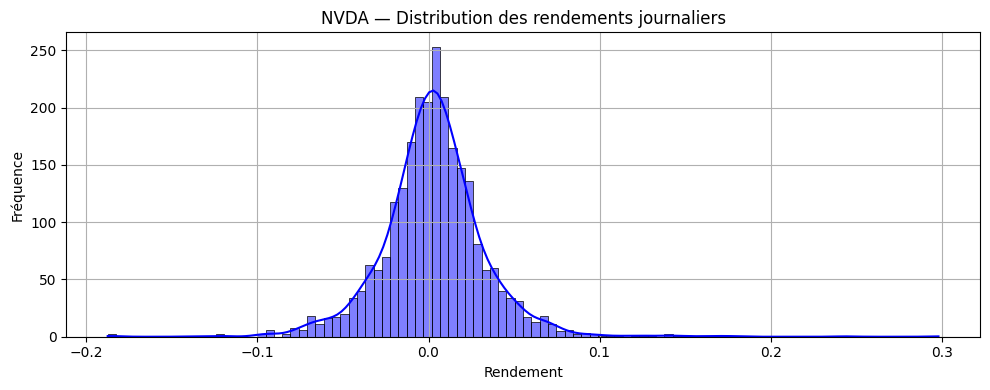

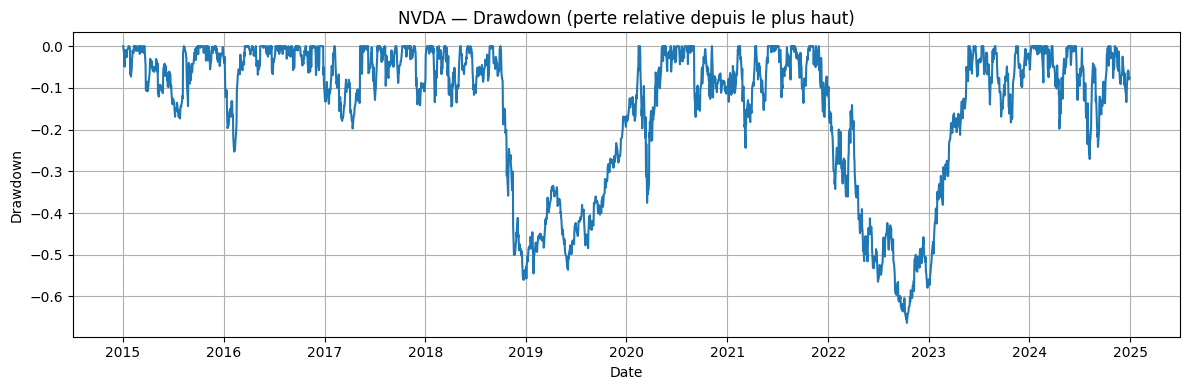

In [169]:
# Histogramme des rendements
df_r = nvda_data.dropna(subset=["ret_NVDA"]).copy()

plt.figure(figsize=(10, 4))
#avec seaborn c'est plus joli que plt
sns.histplot(df_r['ret_NVDA'], bins=100, kde=True, color='blue')
plt.title("NVDA — Distribution des rendements journaliers")
plt.xlabel("Rendement")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.grid()
plt.show()

# Drawdown
df_dd = nvda_data.dropna(subset=["drawdown_NVDA"]).copy()

plt.figure(figsize=(12, 4))
plt.plot(df_dd["Date"], df_dd["drawdown_NVDA"])
plt.title("NVDA — Drawdown (perte relative depuis le plus haut)")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.tight_layout()
plt.grid()
plt.show()


**Interprétations** : les rendements journaliers globalement centrés autour de zéro, mais avec des **queues épaisses**. Les rendements suivent une normale. 

Le graphique de drawdown montre des épisodes extrêmes en pertes cumulées depuis un sommet : on observe plusieurs phases de correction, avec des drawdowns profonds autour de 2018–2019 et surtout 2022–2023, avant des phases de récupération. 

Ensemble, ces deux visualisations confirment que NVDA est un actif à **fort potentiel directionnel** mais également exposé à des **corrections importantes**. 

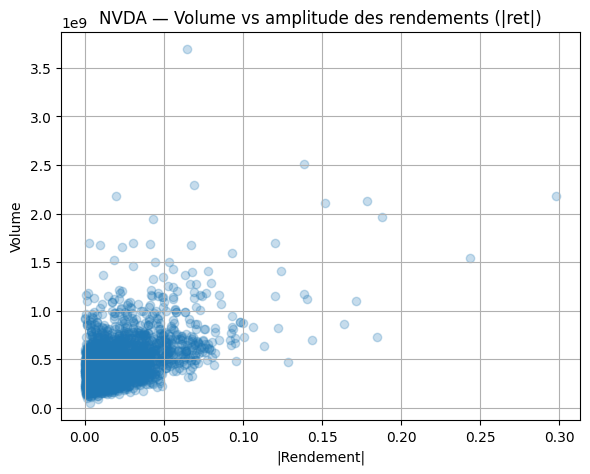

In [170]:
df_sc = nvda_data.dropna(subset=["ret_NVDA", "Volume_NVDA"]).copy()

#Amplitude des mouvements
df_sc["abs_ret"] = df_sc["ret_NVDA"].abs()

plt.figure(figsize=(6, 5))
plt.scatter(df_sc["abs_ret"], df_sc["Volume_NVDA"], alpha=0.25)
plt.title("NVDA — Volume vs amplitude des rendements (|ret|)")
plt.xlabel("|Rendement|")
plt.ylabel("Volume")
plt.tight_layout()
plt.grid()
plt.show()

**Interprétations** : Le nuage de points suggère une relation positive entre l’intensité des variations de prix et le volume échangé : lorsque les mouvements journaliers sont plus importants, l’activité de marché tend à augmenter. 

La dispersion reste toutefois élevée, ce qui indique que le volume dépend aussi d’autres facteurs. 


## B.6 — Corrélations ciblées (sur variations)

Une corrélation calculée sur toutes les colonnes est peu lisible et souvent trompeuse (notamment sur les niveaux de prix).  
On calcule donc une corrélation sur des transformations pertinentes : rendements des actifs (NVDA/ETFs) et variations des indicateurs macro (ΔVIX, Δtaux 10 ans).


In [ ]:
corr_df = pd.DataFrame({"Date": nvda_data_2["Date"]})
#Returns NVDA + ETFs
for col in ["Close_NVDA", "Close_SPY", "Close_QQQ", "Close_SOXX"]:
    if col in nvda_data_2.columns:
        s = pd.to_numeric(nvda_data_2[col], errors="coerce")
        corr_df[f"ret_{col.split('_')[1]}"] = s.pct_change()

#ΔVIX, ΔDGS10
if "VIXCLS" in nvda_data_2.columns:
    corr_df["dVIX"] = pd.to_numeric(nvda_data_2["VIXCLS"], errors="coerce").diff()
if "DGS10" in nvda_data_2.columns:
    corr_df["dDGS10"] = pd.to_numeric(nvda_data_2["DGS10"], errors="coerce").diff()

corr_df = corr_df.dropna().drop(columns=["Date"])

corr_matrix = corr_df.corr()
corr_matrix


,ret_NVDA,ret_SPY,ret_QQQ,ret_SOXX,dVIX,dDGS10
ret_NVDA,1.000000,0.635376,0.730455,0.790222,-0.502126,0.066153
ret_SPY,0.635376,1.000000,0.929285,0.815244,-0.777950,0.163531
ret_QQQ,0.730455,0.929285,1.000000,0.869892,-0.724114,0.105789
ret_SOXX,0.790222,0.815244,0.869892,1.000000,-0.632965,0.116483
dVIX,-0.502126,-0.777950,-0.724114,-0.632965,1.000000,-0.168549
dDGS10,0.066153,0.163531,0.105789,0.116483,-0.168549,1.000000


C